In [1]:
# importing required libraries

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from lightgbm import LGBMRegressor
from tqdm import tqdm
from datetime import timedelta
from sklearn.metrics import mean_squared_log_error as msle

In [2]:
# read the dataset
data = pd.read_csv('Data/final_data.csv')

In [3]:
# check for the null values
data.isna().sum().sum()

0

In [4]:
# drop the columns that are not required
data = data.drop(columns= ['2_MONTH_BEFORE', '1_WEEK_BEFORE'])

In [5]:
data.WEEK_END_DATE = pd.to_datetime(data.WEEK_END_DATE)

In [6]:
week = data.WEEK_END_DATE.unique()

In [7]:
def validation_df(data, week, no_of_months, no_of_validation):
    
    model_set = []
    set_n = 1
    for w in range(len(week)-1,0,-1):
        x_data = {}

        x_data['train_start_1'] = week[w-3-4*no_of_months]
        x_data['train_end_1'] = week[w-4]
        x_data['train_start_2'] = week[w-1-4*no_of_months]
        x_data['validate_week'] = week[w-2]
        x_data['test_week'] = week[w]
        x_data['no_days_train_1'] = x_data['train_end_1'] - x_data['train_start_1']
        x_data['no_days_train_2'] = x_data['validate_week'] - x_data['train_start_2']
        x_data['set_no'] = 'set'+str(set_n)
        set_n +=1
        model_set.append(x_data)
        if(len(model_set) == no_of_validation):
            break
        

    df = pd.DataFrame.from_dict(model_set)
    df['no_days_train_1'] = df['no_days_train_1'] + timedelta(days=7)
    df['no_days_train_2'] = df['no_days_train_2'] + timedelta(days=7)
    return df    

In [8]:
validation_df(data, week, no_of_months=2, no_of_validation = 14)

,train_start_1,train_end_1,train_start_2,validate_week,test_week,no_days_train_1,no_days_train_2,set_no
0,2011-07-13,2011-08-31,2011-07-27,2011-09-14,2011-09-28,56 days,56 days,set1
1,2011-07-06,2011-08-24,2011-07-20,2011-09-07,2011-09-21,56 days,56 days,set2
2,2011-06-29,2011-08-17,2011-07-13,2011-08-31,2011-09-14,56 days,56 days,set3
3,2011-06-22,2011-08-10,2011-07-06,2011-08-24,2011-09-07,56 days,56 days,set4
4,2011-06-15,2011-08-03,2011-06-29,2011-08-17,2011-08-31,56 days,56 days,set5
5,2011-06-08,2011-07-27,2011-06-22,2011-08-10,2011-08-24,56 days,56 days,set6
6,2011-06-01,2011-07-20,2011-06-15,2011-08-03,2011-08-17,56 days,56 days,set7
7,2011-05-25,2011-07-13,2011-06-08,2011-07-27,2011-08-10,56 days,56 days,set8
8,2011-05-18,2011-07-06,2011-06-01,2011-07-20,2011-08-03,56 days,56 days,set9
9,2011-05-11,2011-06-29,2011-05-25,2011-07-13,2011-07-27,56 days,56 days,set10


In [9]:
# define a function to calculate the evaluation sets.
# this time we will include test set also
def get_evaluation_sets(data, df):
    evaluation_set = []
    
    for row in range(df.shape[0]):
        print(df.loc[row]['set_no'])
        # get the train data 1
        train_data_1 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_1']) & (data.WEEK_END_DATE <= df.loc[row]['train_end_1'])]        
        # get the validate data
        validation_data = data[data.WEEK_END_DATE == df.loc[row]['validate_week']]
        # get the train data 2
        train_data_2 = data[(data.WEEK_END_DATE >= df.loc[row]['train_start_2']) & (data.WEEK_END_DATE <= df.loc[row]['validate_week'])]
        # get the test data
        test_data = data[data.WEEK_END_DATE == df.loc[row]['test_week']]
        evaluation_set.append((train_data_1, validation_data, train_data_2, test_data))
    return evaluation_set

In [10]:
# get the evaluation sets
evaluation_sets = get_evaluation_sets(data,
                                      validation_df(data,
                                                    week,
                                                    no_of_months= 2,
                                                    no_of_validation=14)
                                     )

set1
set2
set3
set4
set5
set6
set7
set8
set9
set10
set11
set12
set13
set14


In [11]:
# function to calculate the root mean squared log error
def get_msle(y_true ,y_pred) :
    score = np.sqrt(msle(y_true, y_pred))
    return 'rmsle',score, False

In [12]:
def get_results_on_evaluation_set(eval_set, model):
    results = []
    set_n = 1
    for eval_data in tqdm(eval_set):
        
        x = {}
        train_data_1, validate, train_data_2, test = eval_data
        
        # separate the independent and target variables from train and valid
        train_data_1_x = train_data_1.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_1_y = train_data_1['UNITS']
        
        validate_x = validate.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        validate_y = validate['UNITS']
        
        train_data_2_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        train_data_2_y = train_data_2['UNITS']
        
        test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
        test_y = test['UNITS']
        
        
        # fit the model on the training data
        model_valid = model.fit(train_data_1_x, train_data_1_y)
        
        # predict the target on train and validate
        predict_train_1 = model_valid.predict(train_data_1_x).clip(min=0)
        predict_valid   = model_valid.predict(validate_x).clip(min=0)
                
        
        # fit the model on the training data
        model_test  = model.fit(train_data_2_x, train_data_2_y)
        
        # predict the target on train and test
        predict_train_2 = model_test.predict(train_data_2_x).clip(min=0)
        predict_test    = model_test.predict(test_x).clip(min=0)
        
        
        # calculate the rmsle on train and valid
        rmsle_train_1 = get_msle(train_data_1_y, predict_train_1)
        rmsle_valid   = get_msle(validate_y, predict_valid)
        
        # calculate the rmsle on train and test
        rmsle_train_2 = get_msle(train_data_2_y, predict_train_2)
        rmsle_test    = get_msle(test_y, predict_test)
        
        
        x['set_no'] = set_n
        set_n +=1
        x['rmsle_train_1'] = rmsle_train_1
        x['rmsle_valid'] = rmsle_valid
        x['rmsle_train_2'] = rmsle_train_2
        x['rmsle_test'] = rmsle_test
        results.append(x)
        
        
    return pd.DataFrame.from_dict(results)

In [13]:
# define function to get the best 10 feature importance plot
def get_feature_importance(eval_set, model):
    train_data_1, validate, train_data_2, test = eval_set
    
    train_data_x = train_data_2.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    train_data_y = train_data_2['UNITS']
        
    test_x = test.drop(columns= ['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'UNITS'])
    test_y = test['UNITS']
    
    model.fit(train_data_x, train_data_y)
    (pd.Series(model.feature_importances_, index=train_data_x.columns).nlargest(10).plot(kind='barh')) 

### LightGBM Model

In [14]:
# define the xgboost model
model = lgb.LGBMRegressor(n_estimators = 500,
                             max_depth = 4,
                             num_leaves = 2,
                             learning_rate = 0.01,
                             n_jobs = 4,
                             random_state = 0,
                             objective ='regression')

In [15]:
# calculate the results using lightgbm
results = get_results_on_evaluation_set(evaluation_sets, model)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:10<00:00,  1.36it/s]


In [16]:
print(results.columns)

Index(['set_no', 'rmsle_train_1', 'rmsle_valid', 'rmsle_train_2',
       'rmsle_test'],
      dtype='object')


In [17]:
results.head()

,set_no,rmsle_train_1,rmsle_valid,rmsle_train_2,rmsle_test
0,1,"(rmsle, 0.595809992849133, False)","(rmsle, 0.5093159162444482, False)","(rmsle, 0.5860261868992122, False)","(rmsle, 0.5469749939867522, False)"
1,2,"(rmsle, 0.589829732760506, False)","(rmsle, 0.5660215960715542, False)","(rmsle, 0.5940312721875595, False)","(rmsle, 0.5497761339976626, False)"
2,3,"(rmsle, 0.5827737038512516, False)","(rmsle, 0.6895963115610045, False)","(rmsle, 0.595809992849133, False)","(rmsle, 0.5093159162444482, False)"
3,4,"(rmsle, 0.5788371641673505, False)","(rmsle, 0.618865572565177, False)","(rmsle, 0.589829732760506, False)","(rmsle, 0.5660215960715542, False)"
4,5,"(rmsle, 0.5700147190673213, False)","(rmsle, 0.6192905491124185, False)","(rmsle, 0.5827737038512516, False)","(rmsle, 0.6895963115610045, False)"


In [18]:
results['rmsle_train_2'] = results['rmsle_train_2'].astype('str')
results['rmsle_test'] = results['rmsle_test'].astype('str')

In [19]:
new_df = (results['rmsle_train_2'].str.split('(\d\.\d+)', expand = True))
new_df[1] = new_df[1].astype('float')
results['rmsle_train_2'] = new_df[1]

new_df_2 = (results['rmsle_test'].str.split('(\d\.\d+)', expand = True))
new_df_2[1] = new_df_2[1].astype('float')
results['rmsle_test'] = new_df_2[1] 

In [20]:
results.head()

,set_no,rmsle_train_1,rmsle_valid,rmsle_train_2,rmsle_test
0,1,"(rmsle, 0.595809992849133, False)","(rmsle, 0.5093159162444482, False)",0.586026,0.546975
1,2,"(rmsle, 0.589829732760506, False)","(rmsle, 0.5660215960715542, False)",0.594031,0.549776
2,3,"(rmsle, 0.5827737038512516, False)","(rmsle, 0.6895963115610045, False)",0.595810,0.509316
3,4,"(rmsle, 0.5788371641673505, False)","(rmsle, 0.618865572565177, False)",0.589830,0.566022
4,5,"(rmsle, 0.5700147190673213, False)","(rmsle, 0.6192905491124185, False)",0.582774,0.689596


In [21]:
results[['rmsle_train_2', 'rmsle_test']]

,rmsle_train_2,rmsle_test
0,0.586026,0.546975
1,0.594031,0.549776
2,0.595810,0.509316
3,0.589830,0.566022
4,0.582774,0.689596
5,0.578837,0.618866
6,0.570015,0.619291
7,0.568996,0.642370
8,0.565744,0.533069
9,0.560326,0.570336


In [22]:
print(results[['rmsle_train_2', 'rmsle_test']].mean())

rmsle_train_2    0.578421
rmsle_test       0.586582
dtype: float64


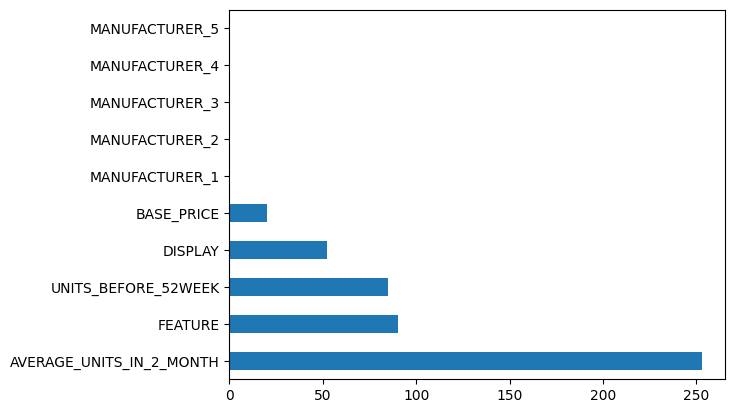

In [23]:
get_feature_importance(evaluation_sets[0], model)